# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [3]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [4]:
fname = "hcp_rest.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [5]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [6]:
fname = "hcp_covariates.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/x5p4g/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [7]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

# Helper functions


## Data loading

In [8]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev = dict(zip(["onset", "duration", "amplitude"], np.genfromtxt(ev_file).T))
    evs.append(ev)
  return evs

## Task-based analysis

In [9]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Resting-state analyses

Load a single run of resting-state data:

In [10]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [11]:
timeseries = load_timeseries(subject=0, name="rest", runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


Load a concatenated resting-state timeseries (using all runs' data) for each subject:

In [12]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, "rest")
  timeseries_rest.append(ts_concat)

## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

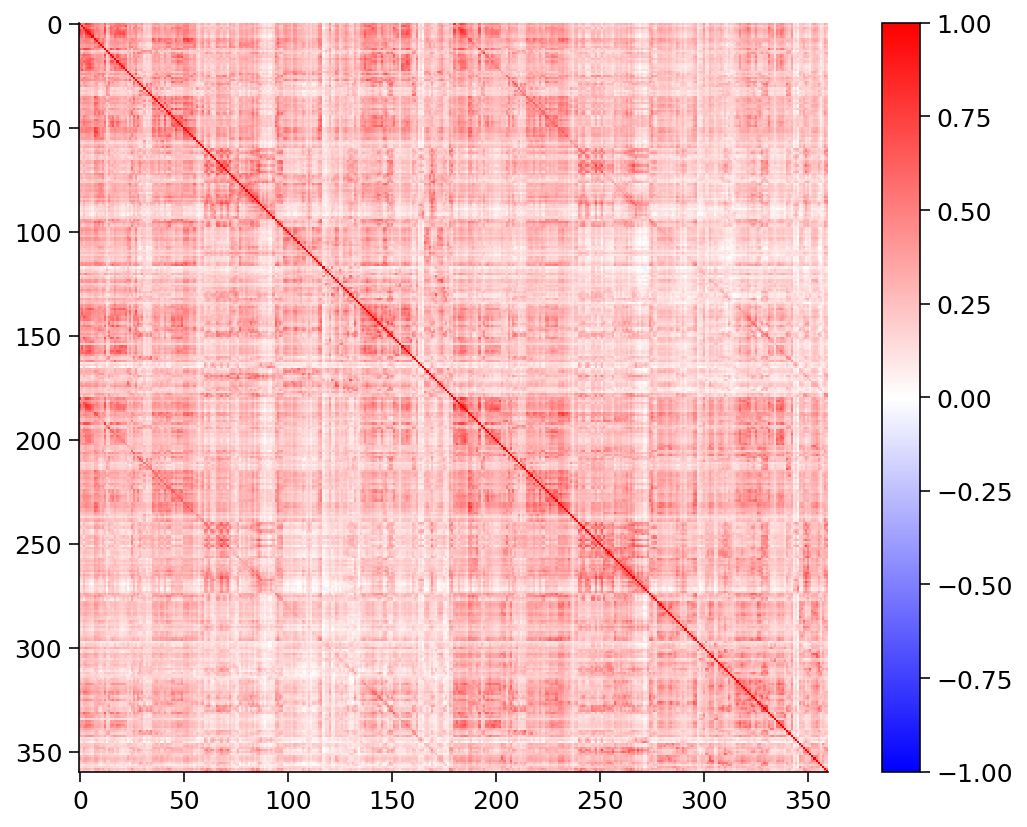

In [13]:
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)

group_fc = fc.mean(axis=0)

plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

Plot the profile of FC values between a particular "seed" parcel and every parcel in the dataset, separated by hemisphere:

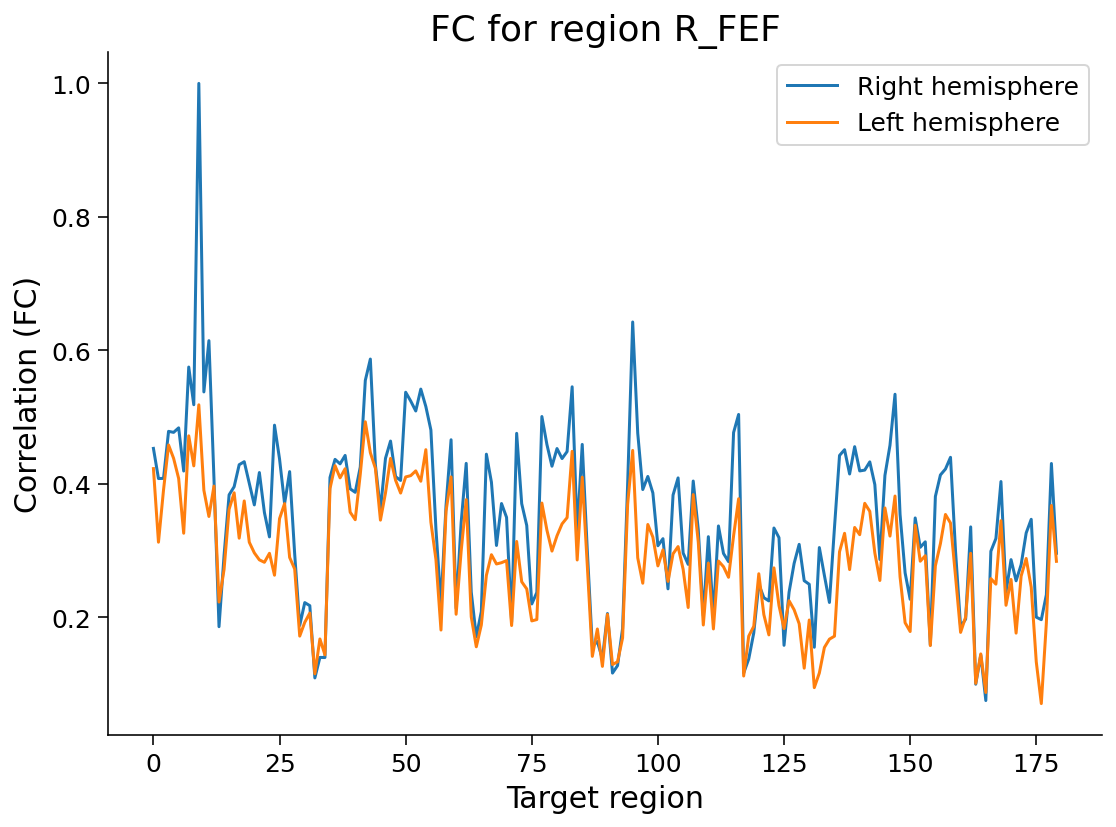

In [14]:
seed_roi = "R_FEF"  # name of seed parcel
ind = region_info["name"].index(seed_roi)

hemi_fc = np.split(group_fc, 2)

# Plot the FC profile across the right and left hemisphere target regions
for i, hemi_fc in enumerate(hemi_fc):
  plt.plot(hemi_fc[:, ind], label=f"{HEMIS[i]} hemisphere")
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target region")
plt.ylabel("Correlation (FC)")
plt.legend()
plt.show()

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

## Load individual runs for a given task

Load each subject's data for a specific task, separately for each run:

In [15]:
timeseries_task = []
for subject in subjects:
  timeseries_task.append(load_timeseries(subject, "social", concat=False))

## Run a simple subtraction analysis

In [16]:
help(load_evs)

Help on function load_evs in module __main__:

load_evs(subject, name, condition)
    Load EV (explanatory variable) data for one task condition.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of task
      condition (str) : Name of condition
    
    Returns
      evs (list of dicts): A dictionary with the onset, duration, and amplitude
        of the condition for each run.



In [17]:
help(selective_average)

Help on function selective_average in module __main__:

selective_average(timeseries_data, ev, skip=0)
    Take the temporal mean across frames for a given condition.
    
    Args:
      timeseries_data (array or list of arrays): n_parcel x n_tp arrays
      ev (dict or list of dicts): Condition timing information
      skip (int) : Ignore this many frames at the start of each trial, to account
        for hemodynamic lag
    
    Returns:
      avg_data (1D array): Data averagted across selected image frames based
      on condition timing



In [18]:
task = "social"
conditions = ["mental", "rnd"]  # Run a substraction analysis between two conditions

contrast = []
GLM_LR_mental = []
GLM_LR_random = []

for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond) for cond in conditions]
  avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

  # Store the region-wise difference
  contrast.append(avgs[0] - avgs[1])

  # Store for GLM-LR
  GLM_LR_mental.append(avgs[0])
  GLM_LR_random.append(avgs[1])

group_contrast = np.mean(contrast, axis=0)

Plot group-averaged contrast value across regions:

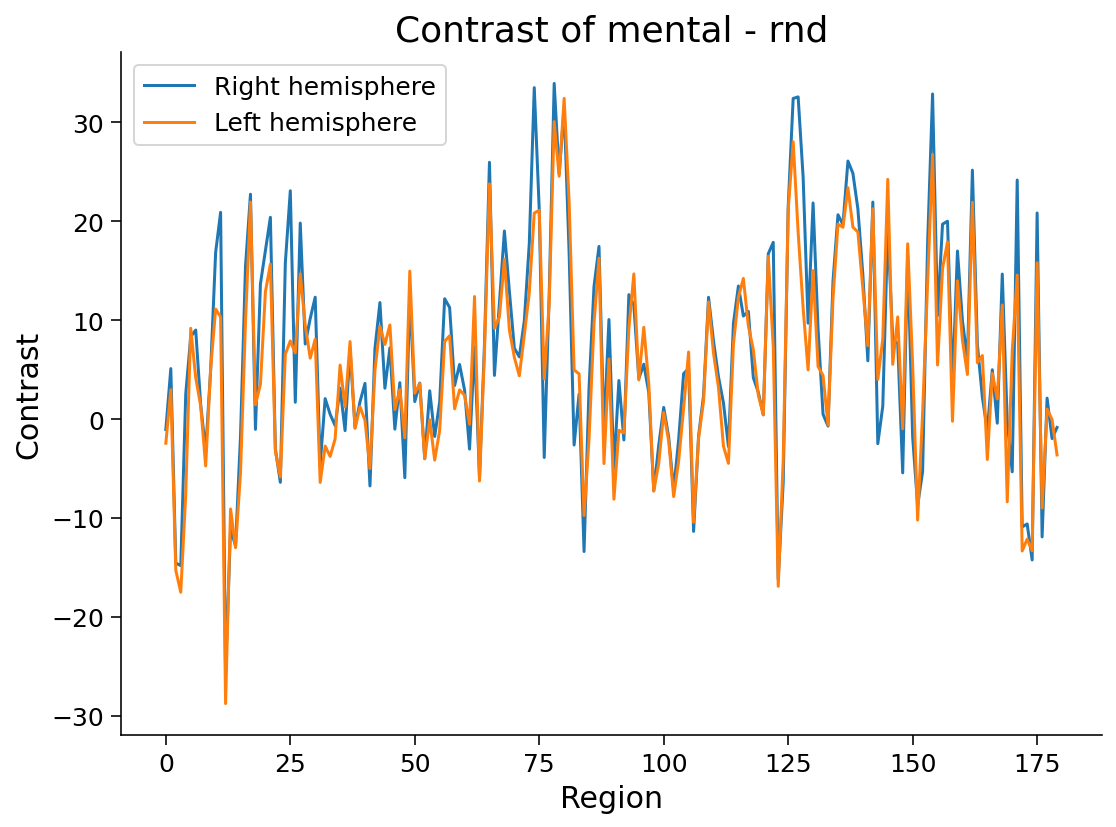

In [19]:
hemi_contrasts = np.split(group_contrast, 2)

for i, hemi_contrast in enumerate(hemi_contrasts):
  plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

plt.title("Contrast of %s - %s" % (conditions[0], conditions[1]))
plt.xlabel("Region")
plt.ylabel('Contrast')
plt.legend()
plt.show()

## Characterize values by functional network

Average the contrast values within parcels belonging to each network and plot:

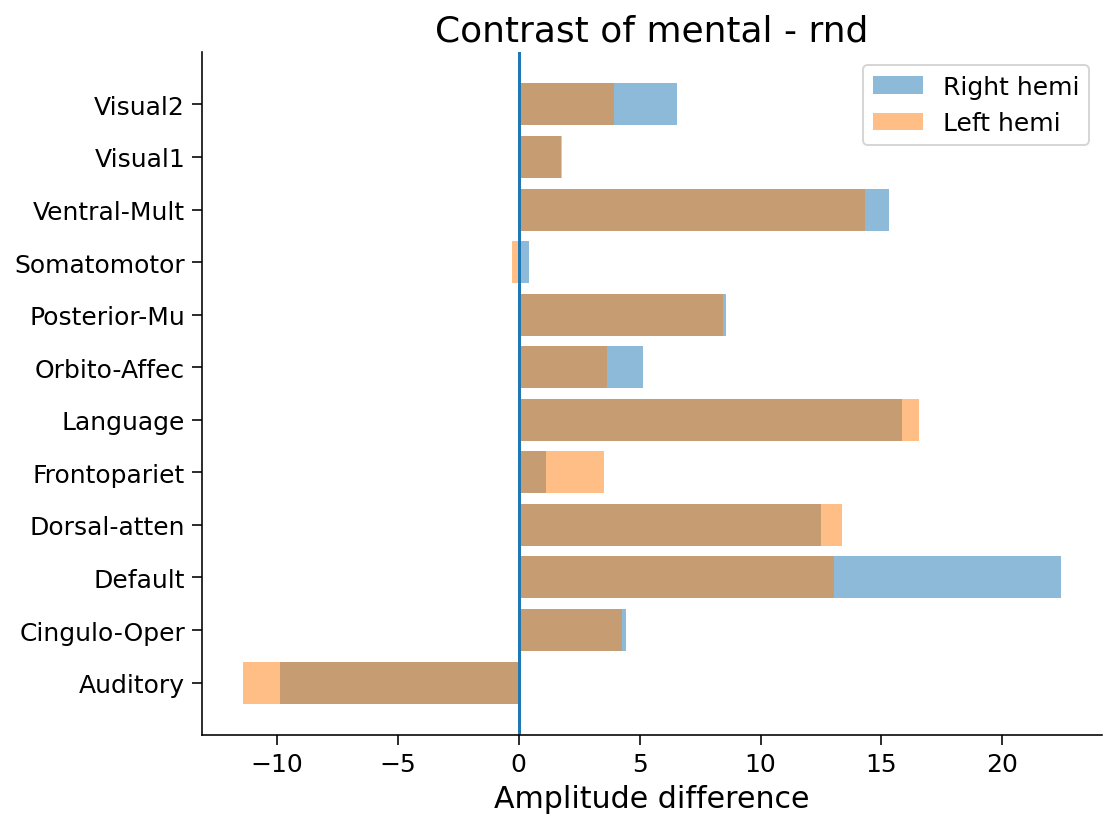

In [20]:
# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast, 2)

# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for network in network_names:
    network_vals.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.legend()
plt.show()

# Simple GLM (Logistic Regression)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [22]:
#@title Helper functions

def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Neuron (a.k.a. feature)")
  f.tight_layout()


def plot_function(f, name, var, points=(-10, 10)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )


def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )

def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, non_zero_l1, marker="o")
  ax.set(
    xticks=C_values,
    xlabel="$C$",
    ylabel="Number of non-zero coefficients",
  )
  ax.axhline(n_voxels, color=".1", linestyle=":")
  ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")

In [23]:
y = []
X = []

for i in range(len(GLM_LR_mental)):
  X.append(GLM_LR_mental[i])
  y.append(1)

for i in range(len(GLM_LR_random)):
  X.append(GLM_LR_random[i])
  y.append(0)

X = np.array(X)
y = np.array(y)

In [24]:
# First define the model
log_reg = LogisticRegression(penalty="none")

#Then fit it to data
log_reg.fit(X, y)

y_pred = log_reg.predict(X)

In [25]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.
  Returns:
    accuracy (float): Proportion of correct predictions.  
  """
  y_pred = model.predict(X)
  accuracy = (y == y_pred).mean()

  return accuracy

train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 100.00%


In [26]:
import copy

for i in range(X.shape[1]):
  XX = copy.copy(X)
  XX = np.delete(XX, i, axis=1)

  #Then fit it to data
  accuracies = cross_val_score(LogisticRegression(penalty='none'), XX, y, cv=8) # k=8 crossvalidation
  
  print("Parcel Number:" + str(i + 1) + "   [" + f"Accuracy on the training data excluding one parcel: {train_accuracy:.2%}]")  

Parcel Number:1   [Accuracy on the training data excluding one parcel: 100.00%]
Parcel Number:2   [Accuracy on the training data excluding one parcel: 100.00%]
Parcel Number:3   [Accuracy on the training data excluding one parcel: 100.00%]
Parcel Number:4   [Accuracy on the training data excluding one parcel: 100.00%]
Parcel Number:5   [Accuracy on the training data excluding one parcel: 100.00%]
Parcel Number:6   [Accuracy on the training data excluding one parcel: 100.00%]
Parcel Number:7   [Accuracy on the training data excluding one parcel: 100.00%]
Parcel Number:8   [Accuracy on the training data excluding one parcel: 100.00%]
Parcel Number:9   [Accuracy on the training data excluding one parcel: 100.00%]
Parcel Number:10   [Accuracy on the training data excluding one parcel: 100.00%]
Parcel Number:11   [Accuracy on the training data excluding one parcel: 100.00%]
Parcel Number:12   [Accuracy on the training data excluding one parcel: 100.00%]
Parcel Number:13   [Accuracy on the t

In [27]:
for i in range(X.shape[1]):
  XX = np.expand_dims(X[:,i], axis=1)

  #Then fit it to data
  accuracies = cross_val_score(LogisticRegression(penalty='none'), XX, y, cv=8) # k=8 crossvalidation 

  if accuracies.mean() > 0.8:
    print("Parcel Number:" + str(i + 1) + "   [" f"Accuracy on the training data: {accuracies.mean():.2%}]")   

Parcel Number:12   [Accuracy on the training data: 83.47%]
Parcel Number:13   [Accuracy on the training data: 80.53%]
Parcel Number:18   [Accuracy on the training data: 84.66%]
Parcel Number:26   [Accuracy on the training data: 81.56%]
Parcel Number:28   [Accuracy on the training data: 80.37%]
Parcel Number:75   [Accuracy on the training data: 89.53%]
Parcel Number:79   [Accuracy on the training data: 86.28%]
Parcel Number:81   [Accuracy on the training data: 85.98%]
Parcel Number:124   [Accuracy on the training data: 80.23%]
Parcel Number:127   [Accuracy on the training data: 86.72%]
Parcel Number:128   [Accuracy on the training data: 91.30%]
Parcel Number:129   [Accuracy on the training data: 86.44%]
Parcel Number:131   [Accuracy on the training data: 84.51%]
Parcel Number:136   [Accuracy on the training data: 81.12%]
Parcel Number:137   [Accuracy on the training data: 81.85%]
Parcel Number:138   [Accuracy on the training data: 83.63%]
Parcel Number:139   [Accuracy on the training da

In [28]:
accuracies = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=8) # k=8 crossvalidation

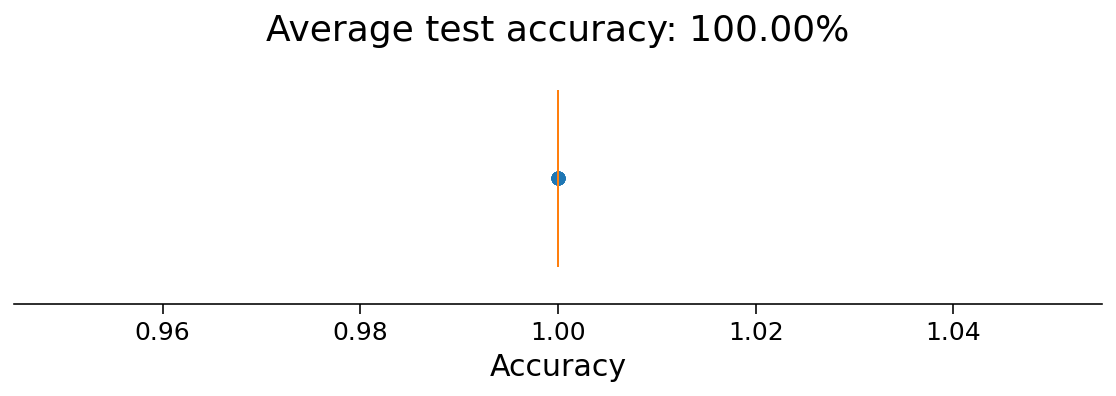

In [29]:
#@title
#@markdown Run to plot out these `k=8` accuracy scores.
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

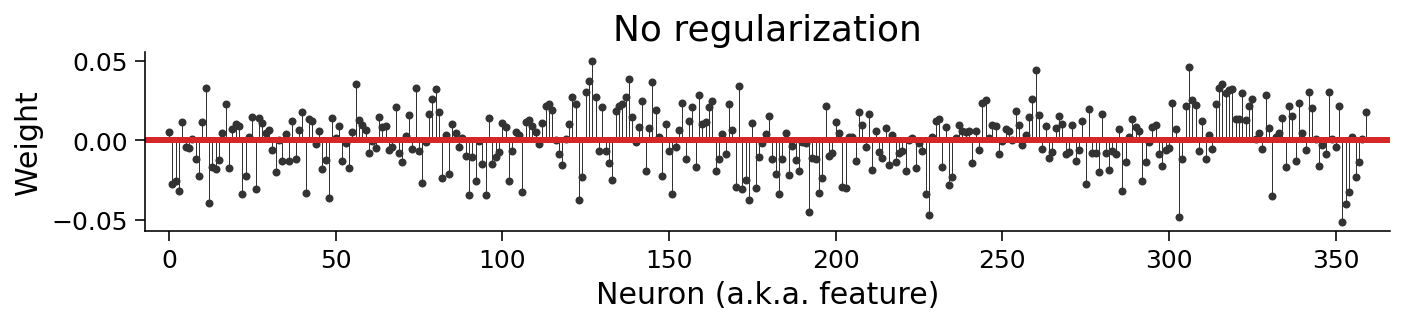

In [30]:
log_reg = LogisticRegression(penalty="none").fit(X, y)
plot_weights({"No regularization": log_reg})

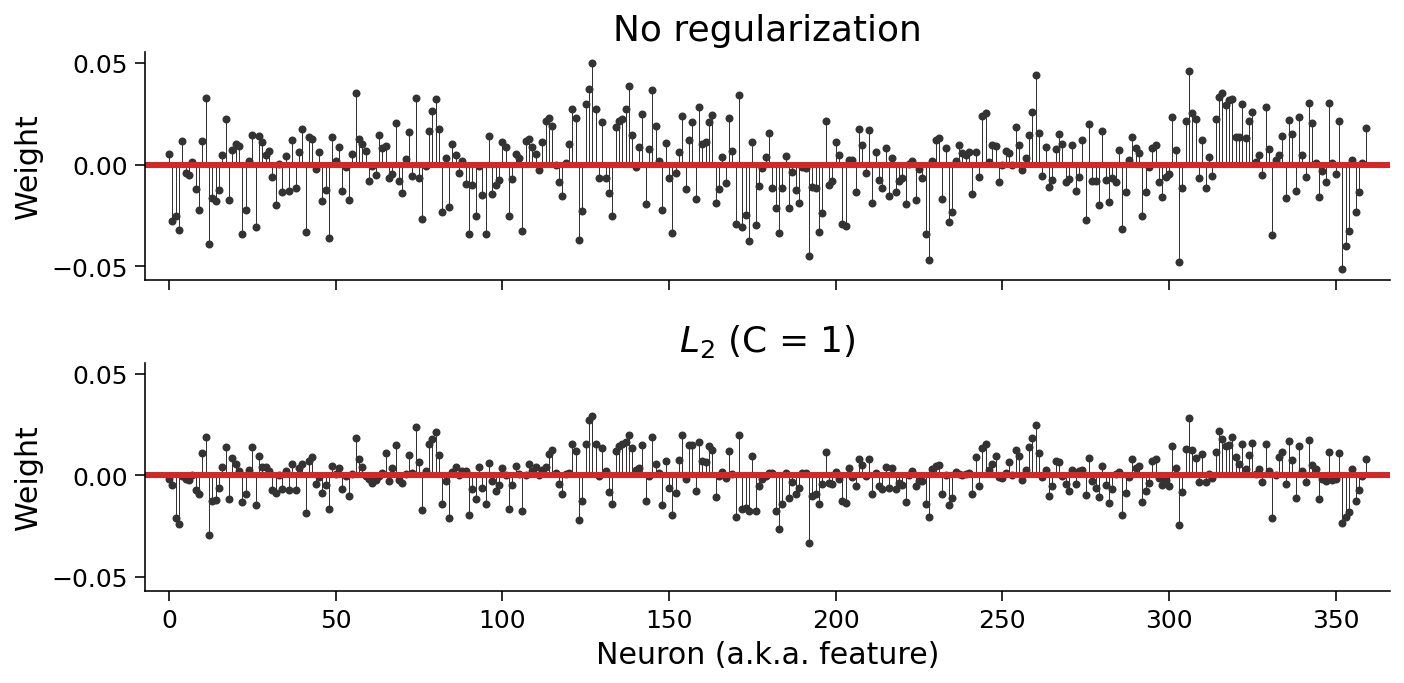

In [31]:
log_reg_l2 = LogisticRegression(penalty="l2", C=1).fit(X, y)

# now show the two models
models = {
  "No regularization": log_reg,
  "$L_2$ (C = 1)": log_reg_l2,
}
plot_weights(models)

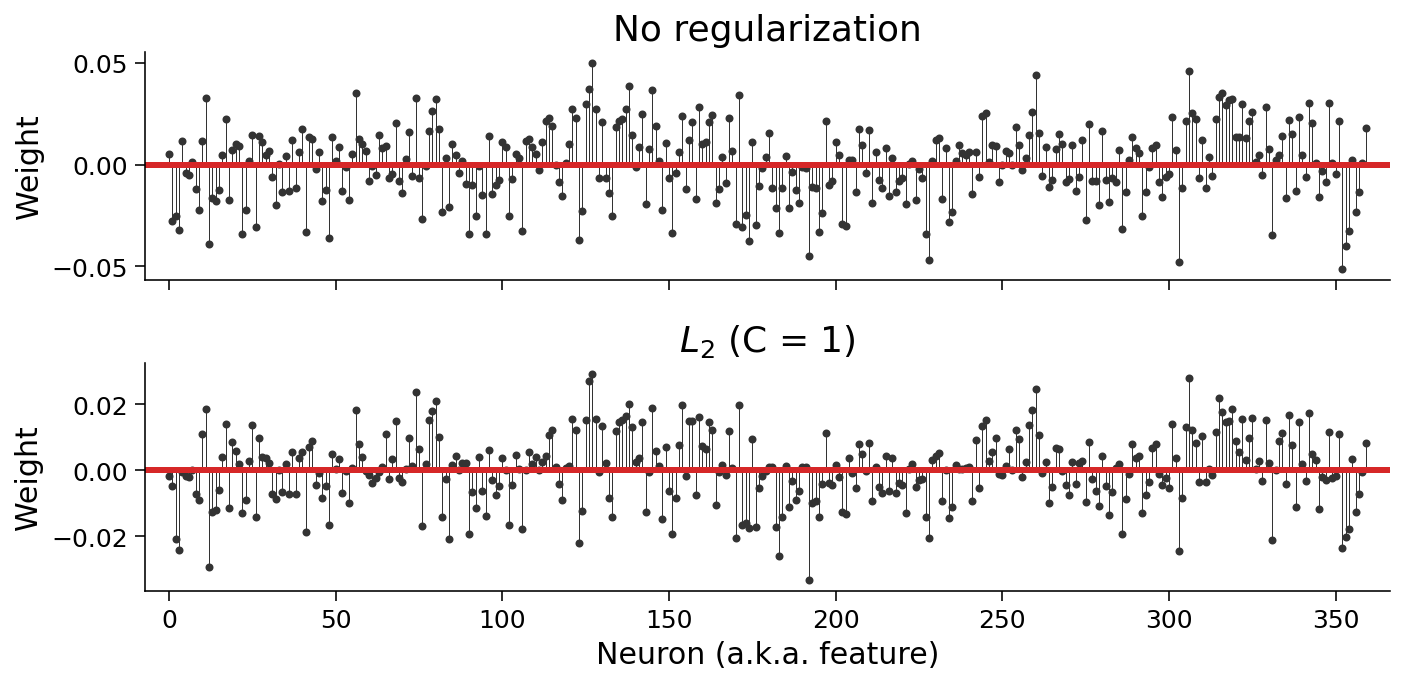

In [32]:
plot_weights(models, sharey=False)

In [33]:
#@title 

#@markdown Execute this cell to enable the widget!
import ipywidgets as widgets

# Precompute the models so the widget is responsive
log_C_steps = 1, 10, 1
penalized_models = {}
for log_C in np.arange(*log_C_steps, dtype=int):
  m = LogisticRegression("l2", C=10 ** log_C, max_iter=5000)
  penalized_models[log_C] = m.fit(X, y)

@widgets.interact
def plot_observed(log_C=log_C_steps):
  models = {
    "No regularization": log_reg,
    f"$L_2$ (C = $10^{log_C}$)": penalized_models[log_C]
  }
  plot_weights(models)

interactive(children=(IntSlider(value=5, description='log_C', max=10, min=1), Output()), _dom_classes=('widget…

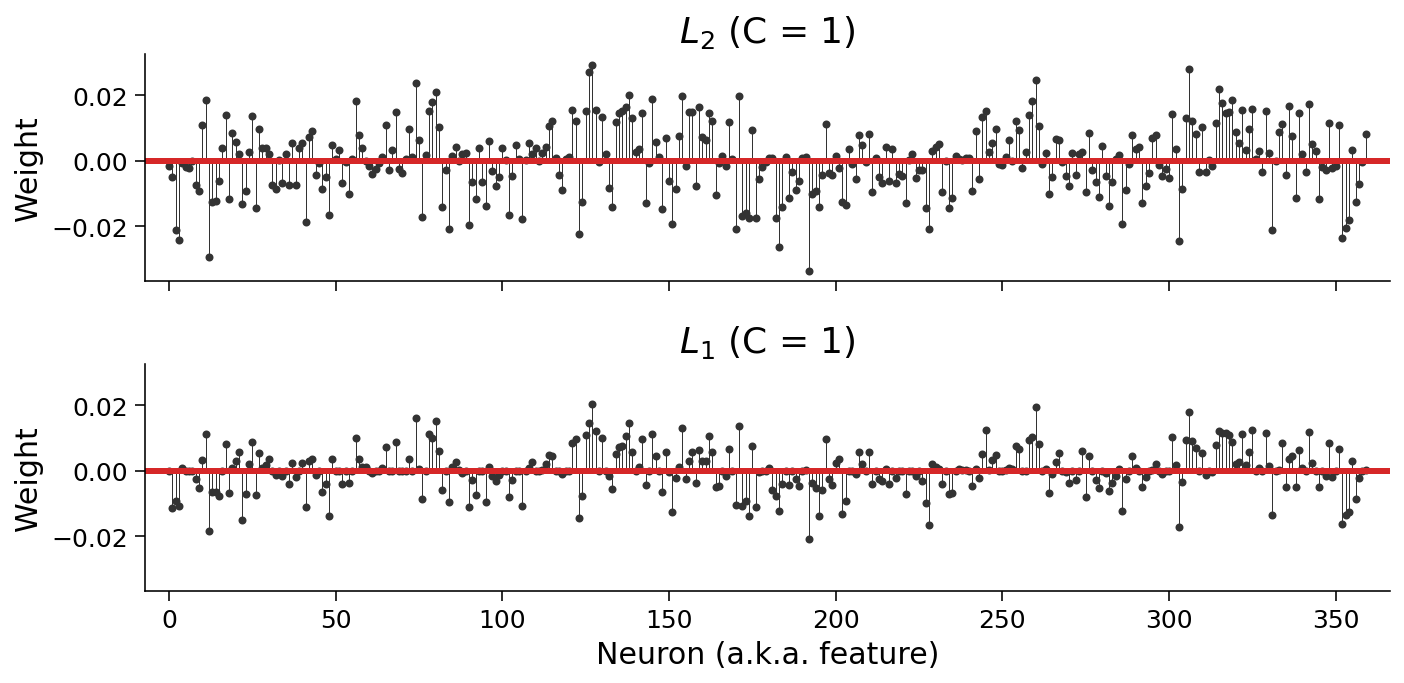

In [34]:
log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
log_reg_l1.fit(X, y)
models = {
  "$L_2$ (C = 1)": log_reg_l2,
  "$L_1$ (C = 1)": log_reg_l1,
}
plot_weights(models)

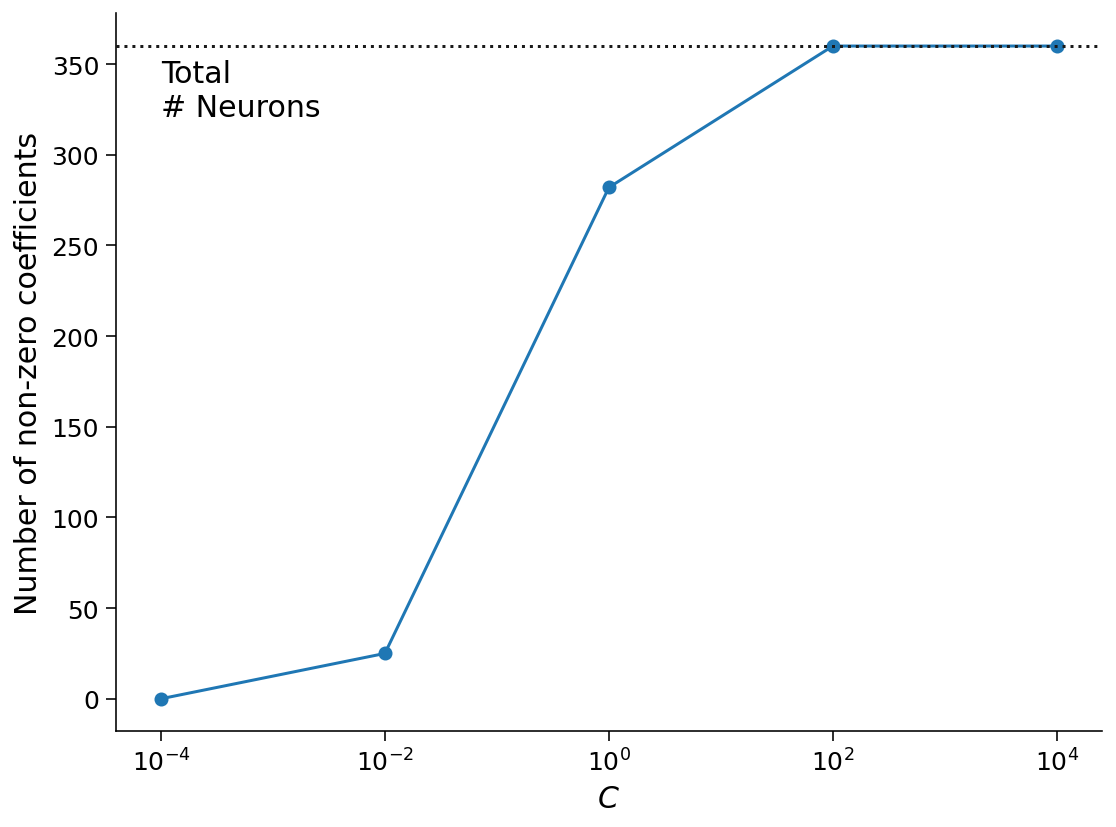

In [36]:
def count_non_zero_coefs(X, y, C_values):
  """Fit models with different L1 penalty values and count non-zero coefficients.
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): List of hyperparameter values
  Returns:
    non_zero_coefs (list): number of coefficients in each model that are nonzero
  """
  non_zero_coefs = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l1", C=C, solver="saga", max_iter=5000)
    model.fit(X,y)

    # Get the coefs of the fit model
    coefs = model.coef_

    # Count the number of non-zero elements in coefs
    non_zero = np.sum(coefs != 0)
    non_zero_coefs.append(non_zero)

  return non_zero_coefs

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 5)

non_zero_l1 = count_non_zero_coefs(X, y, C_values)
plot_non_zero_coefs(C_values, non_zero_l1, n_voxels=X[0].shape[0])

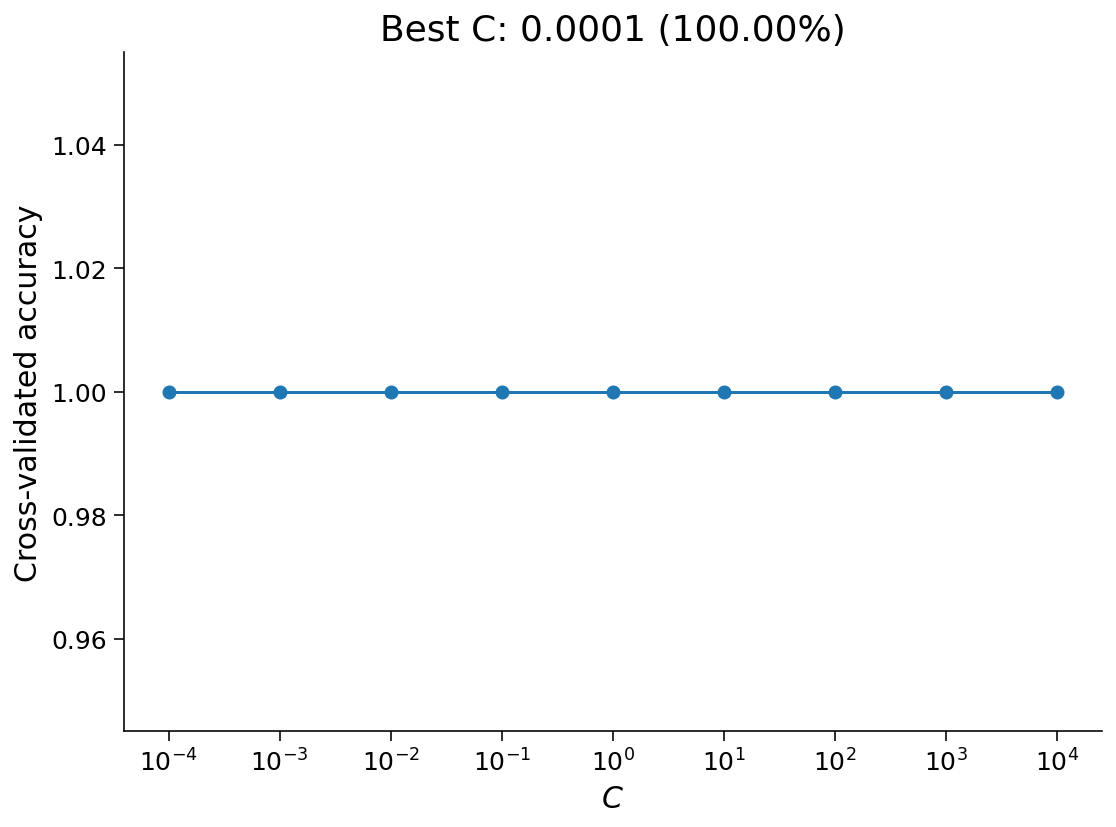

In [37]:
def model_selection(X, y, C_values):
  """Compute CV accuracy for each C value.
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values.
  Returns:
    accuracies (1D array): CV accuracy with each value of C.
  """
  accuracies = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l2", C=C, max_iter=5000)

    # Get the accuracy for each test split
    accs = cross_val_score(model, X, y, cv=8)

    # Store the average test accuracy for this value of C
    accuracies.append(accs.mean())

  return accuracies

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

accuracies = model_selection(X, y, C_values)
plot_model_selection(C_values, accuracies)

# Dimensionality Reduction

## PCA

In [38]:
# @title Helper functions


def plot_eigenvalues(evals):
  """
  Plots eigenvalues.

  Args:
      (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """
  plt.figure(figsize=(4, 4))
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  plt.xticks(np.arange(1, len(evals) + 1))
  plt.ylim([0, 2.5])


def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]
  return evals, evectors


def plot_data(X):
  """
  Plots bivariate data. Includes a plot of each random variable, and a scatter
  scatter plot of their joint activity. The title indicates the sample
  correlation calculated from the data.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(X[:, 0], color='k')
  plt.ylabel('Neuron 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(X[:, 1], color='k')
  plt.xlabel('Sample Number (sorted)')
  plt.ylabel('Neuron 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(X[:, 0], X[:, 1], '.', markerfacecolor=[.5, .5, .5],
           markeredgewidth=0)
  ax3.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(X[:, 0], X[:, 1])[0, 1]))
  plt.show()


def get_data(cov_matrix):
  """
  Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian

  Note that samples are sorted in ascending order for the first random
  variable.

  Args:
    var_1 (scalar)                     : variance of the first random variable
    var_2 (scalar)                     : variance of the second random variable
    cov_matrix (numpy array of floats) : desired covariance matrix

  Returns:
    (numpy array of floats)            : samples from the bivariate Gaussian,
                                          with each column corresponding to a
                                          different random variable
  """

  mean = np.array([0, 0])
  X = np.random.multivariate_normal(mean, cov_matrix, size=1000)
  indices_for_sorting = np.argsort(X[:, 0])
  X = X[indices_for_sorting, :]
  return X


def calculate_cov_matrix(var_1, var_2, corr_coef):
  """
  Calculates the covariance matrix based on the variances and
  correlation coefficient.

  Args:
    var_1 (scalar)         :  variance of the first random variable
    var_2 (scalar)         :  variance of the second random variable
    corr_coef (scalar)     :  correlation coefficient

  Returns:
    (numpy array of floats) : covariance matrix
  """
  cov = corr_coef * np.sqrt(var_1 * var_2)
  cov_matrix = np.array([[var_1, cov], [cov, var_2]])
  return cov_matrix


def define_orthonormal_basis(u):
  """
  Calculates an orthonormal basis given an arbitrary vector u.

  Args:
    u (numpy array of floats) : arbitrary 2D vector used for new basis

  Returns:
    (numpy array of floats)   : new orthonormal basis columns correspond to
                                basis vectors
  """

  u = u / np.sqrt(u[0] ** 2 + u[1] ** 2)
  w = np.array([-u[1], u[0]])
  W = np.column_stack((u, w))
  return W


def plot_data_new_basis(Y):
  """
  Plots bivariate data after transformation to new bases. Similar to plot_data
  but with colors corresponding to projections onto basis 1 (red) and
  basis 2 (blue).
  The title indicates the sample correlation calculated from the data.

  Note that samples are re-sorted in ascending order for the first random
  variable.

  Args:
    Y (numpy array of floats) : Data matrix in new basis each column
                                corresponds to a different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(Y[:, 0], 'r')
  plt.ylabel('Projection \n basis vector 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(Y[:, 1], 'b')
  plt.xlabel('Projection \n basis vector 1')
  plt.ylabel('Projection \n basis vector 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(Y[:, 0], Y[:, 1], '.', color=[.5, .5, .5])
  ax3.axis('equal')
  plt.xlabel('Projection basis vector 1')
  plt.ylabel('Projection basis vector 2')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(Y[:, 0], Y[:, 1])[0, 1]))
  plt.show()


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)
  return Y


def plot_basis_vectors(X, W):
  """
  Plots bivariate data as well as new basis vectors.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    W (numpy array of floats) : Square matrix representing new orthonormal
                                basis each column represents a basis vector

  Returns:
    Nothing.
  """

  plt.figure(figsize=[4, 4])
  plt.plot(X[:, 0], X[:, 1], '.', color=[.5, .5, .5], label='Data')
  plt.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.plot([0, W[0, 0]], [0, W[1, 0]], color='r', linewidth=3,
           label='Basis vector 1')
  plt.plot([0, W[0, 1]], [0, W[1, 1]], color='b', linewidth=3,
           label='Basis vector 2')
  plt.legend()
  plt.show()

In [39]:
def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X
  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
  Returns:
    (numpy array of floats)   : Covariance matrix
  """

  # Subtract the mean of X
  X = X - np.mean(X, 0)
  # Calculate the covariance matrix (hint: use np.matmul)
  cov_matrix = cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)

  return cov_matrix

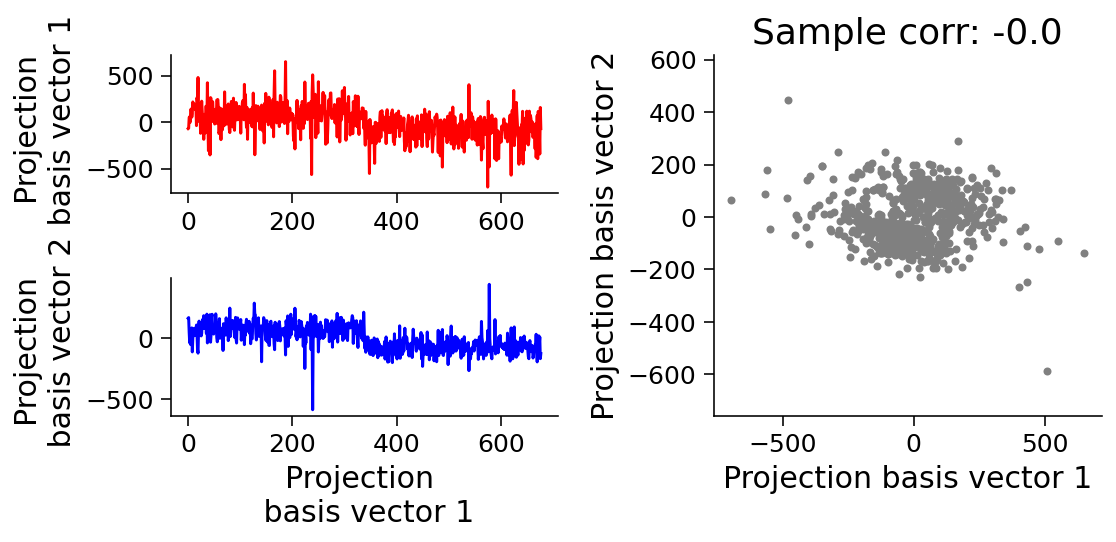

In [40]:
def pca(X):
  """
  Performs PCA on multivariate data.
  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
  Returns:
    (numpy array of floats)   : Data projected onto the new basis
    (numpy array of floats)   : Vector of eigenvalues
    (numpy array of floats)   : Corresponding matrix of eigenvectors
  """

  # Subtract the mean of X
  X = X - np.mean(X, axis=0)
  # Calculate the sample covariance matrix
  cov_matrix = get_sample_cov_matrix(X)
  # Calculate the eigenvalues and eigenvectors
  evals, evectors = np.linalg.eigh(cov_matrix)
  # Sort the eigenvalues in descending order
  evals, evectors = sort_evals_descending(evals, evectors)
  # Project the data onto the new eigenvector basis
  score = change_of_basis(X, evectors)

  return score, evectors, evals


# Perform PCA on the data matrix X
score, evectors, evals = pca(X)
# Plot the data projected into the new basis
plot_data_new_basis(score)

In [41]:
# @title Helper Functions


def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()

def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)

  return Y


def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
"""

  X = X - np.mean(X, 0)
  cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
  return cov_matrix


def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]

  return evals, evectors


def pca(X):
  """
  Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

  Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

  Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Vector of eigenvalues
    (numpy array of floats)    : Corresponding matrix of eigenvectors

  """

  X = X - np.mean(X, 0)
  cov_matrix = get_sample_cov_matrix(X)
  evals, evectors = np.linalg.eigh(cov_matrix)
  evals, evectors = sort_evals_descending(evals, evectors)
  score = change_of_basis(X, evectors)

  return score, evectors, evals


def plot_eigenvalues(evals, limit=True):
  """
  Plots eigenvalues.

  Args:
     (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  if limit:
    plt.show()

(0.0, 100.0)

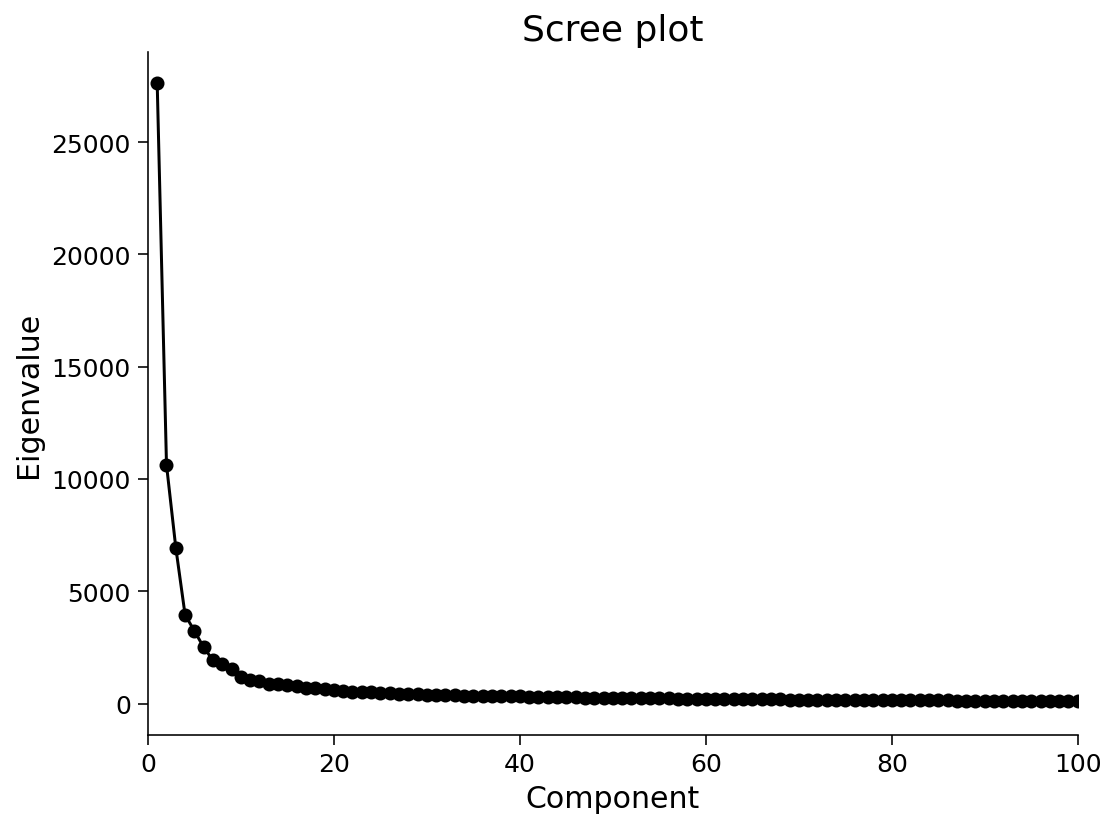

In [42]:
# perform PCA
score, evectors, evals = pca(X)

# plot the eigenvalues
plot_eigenvalues(evals, limit=False)
plt.xlim([0, 100])  # limit x-axis up to 100 for zooming

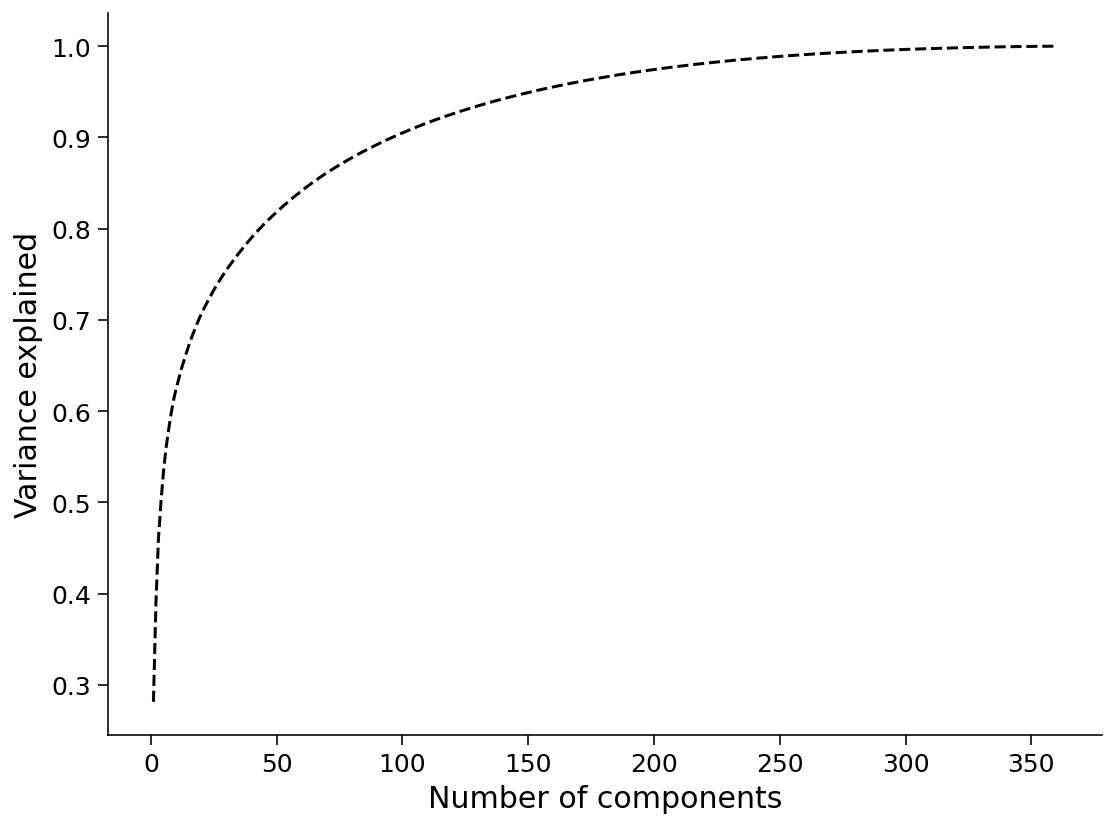

In [43]:
def get_variance_explained(evals):
  """
  Plots eigenvalues.
  Args:
    (numpy array of floats) : Vector of eigenvalues
  Returns:
    Nothing.
  """

  # cumulatively sum the eigenvalues
  csum = np.cumsum(evals)
  # normalize by the sum of eigenvalues
  variance_explained = csum / np.sum(evals)

  return variance_explained


# calculate the variance explained
variance_explained = get_variance_explained(evals)
plot_variance_explained(variance_explained)

# t-SNE

In [44]:
#@title Helper functions


def visualize_components(component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  cmap = plt.cm.get_cmap('tab10')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar(ticks=range(2))
  plt.clim(-0.5, 9.5)
  if show:
    plt.show()

In [45]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=2) # Initializes PCA
pca_model.fit(X) # Performs PCA 

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

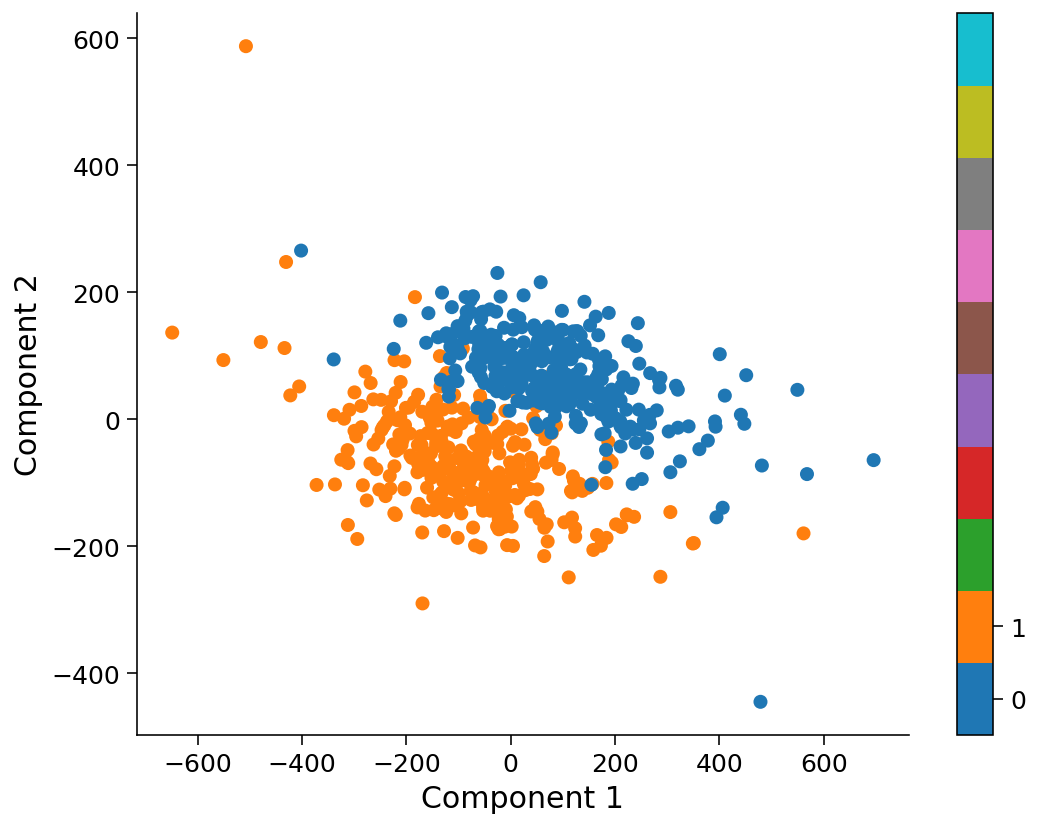

In [46]:
# Perform PCA 
scores = pca_model.transform(X)

# Plot the data and reconstruction
visualize_components(scores[:, 0], scores[:, 1], y)

In [47]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=10, random_state=2020) 

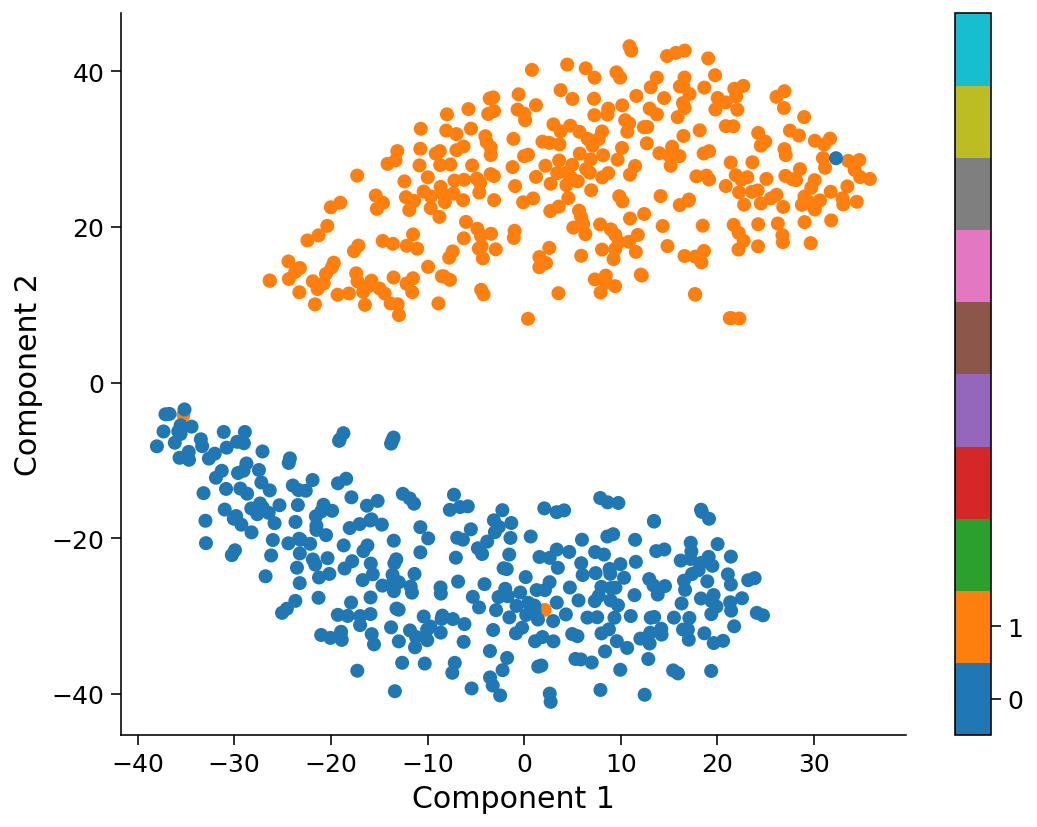

In [48]:
# perform t-SNE
embed = tsne_model.fit_transform(X)

# Visualize the data
visualize_components(embed[:, 0], embed[:, 1], y)

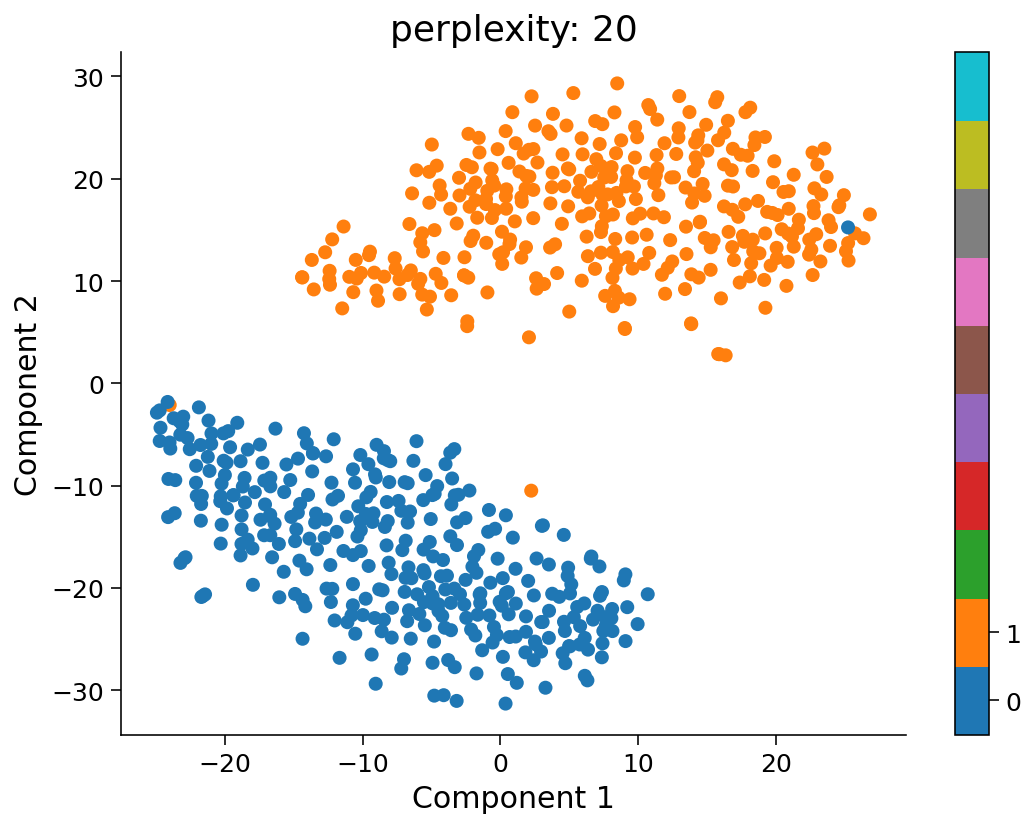

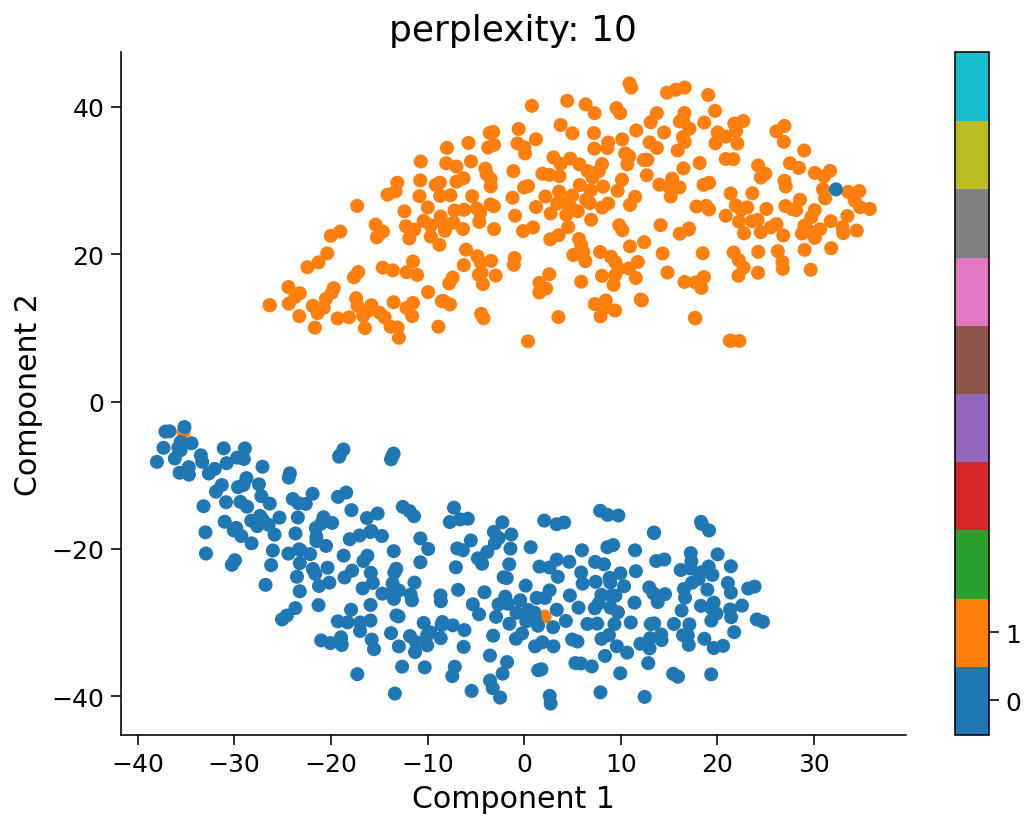

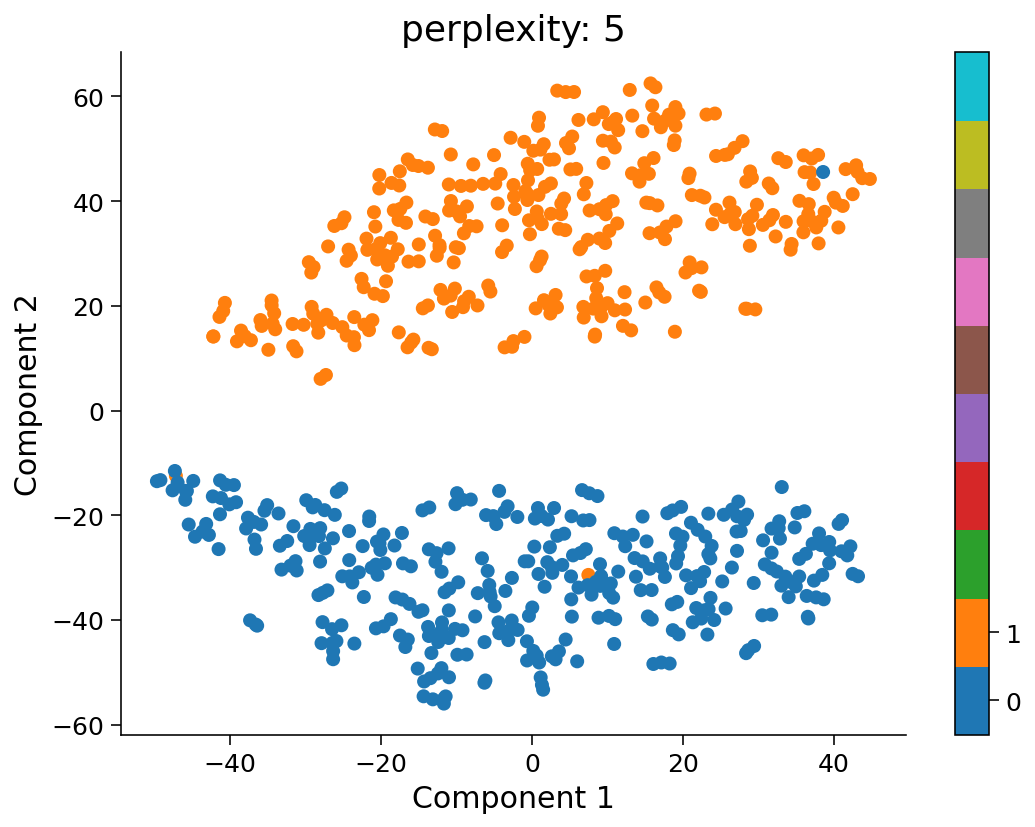

In [49]:
def explore_perplexity(values):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors using different perplexities.
  Args:
    values (list of floats) : list with perplexities to be visualized
  Returns:
    Nothing.
  """

  for perp in values:

    # perform t-SNE
    tsne_model = TSNE(n_components=2, perplexity=perp, random_state=2020) 

    embed = tsne_model.fit_transform(X)
    visualize_components(embed[:, 0], embed[:, 1], y, show=False)
    plt.title(f"perplexity: {perp}")
    plt.show()


# Uncomment when you complete the function
values = [20, 10, 5]

explore_perplexity(values)

# Behavioral covariates


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

In [50]:
social_behavior = np.genfromtxt("hcp/behavior/social.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(social_behavior[:5])
print(social_behavior.dtype.names)

[(0, 0, 'RANDOM',  866.5,    nan, nan, 0., 1., 0., 0.)
 (0, 0, 'TOM',    nan, 1090. , nan, 0., 0., 1., 0.)
 (0, 1, 'RANDOM', 1355. ,    nan, nan, 0., 1., 0., 0.)
 (0, 1, 'TOM',    nan, 1619.5, nan, 0., 0., 1., 0.)
 (1, 0, 'RANDOM',  452. ,    nan, nan, 0., 1., 0., 0.)]
('Subject', 'Run', 'ConditionName', 'MEDIAN_RT_RANDOM', 'MEDIAN_RT_TOM', 'MEDIAN_RT_UNSURE', 'PROP_NLR', 'PROP_RANDOM', 'PROP_TOM', 'PROP_UNSURE')


But, while not formally taught as part of the course, [`pandas`](https://pandas.pydata.org/) offers more powerful tools for tabular data analysis.

## Pseudo-demographics

The NMA-distributed version of the HCP data does not contain any real demographic information. But we have created a synthetic dataset of 25 "demographic" variables based on a model trained on the original dataset to predict demographics from resting-state network organization measures:

In [51]:
demo = np.load("hcp/pseudo_demographics.npy")
demo.shape

(339, 25)

## Original subject IDs

The dataset also contains a key to map the ordinal subject numbers to the IDs used in the original HCP dataset:

In [52]:
ids = np.loadtxt("hcp/orig_ids.txt")
print(ids[:8])

[199453. 580751. 173435. 919966. 181636. 192843. 894067. 174437.]
